In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# utility functions I'll always use?

def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, dev):
  if isinstance(data, (list, tuple)):
    return [to_device(x, dev) for x in data]
  return data.to(dev, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, dev):
    self.dl = dl
    self.device = dev

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [4]:
device = get_device()

# Data 

In [5]:
data_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/kaggle-data/kaggle-digitrecognizer/train.csv')
data_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df, valid_df = train_test_split(data_df, train_size=0.8, random_state=0, shuffle=True, stratify=data_df[['label']])
train_df['label'].nunique() == valid_df['label'].nunique(), len(train_df), len(valid_df)

(True, 33600, 8400)

In [7]:
n_classes = train_df['label'].nunique()

X_train = train_df[train_df.columns[1:]].to_numpy()
X_train = np.reshape(X_train, (len(X_train), 1, 28, 28))

X_valid = valid_df[valid_df.columns[1:]].to_numpy()
X_valid = np.reshape(X_valid, (len(X_valid), 1, 28, 28))

Y_train = train_df['label'].to_numpy()
Y_valid = valid_df['label'].to_numpy()

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((33600, 1, 28, 28), (33600,), (8400, 1, 28, 28), (8400,))

In [8]:
batch_size = 16

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.int64)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.int64)

train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_valid, Y_valid)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

len(train_dl), len(valid_dl), X_train.dtype, X_valid.dtype

(2100, 525, torch.float32, torch.float32)

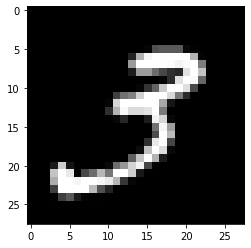

3

In [9]:
for x, y in train_dl:
  break

img = x[0][0].cpu().numpy()
lbl = y[0].item()

plt.imshow(img, cmap='gray')
plt.show()
lbl

# Model #

In [10]:
class MNISTDigitRecognizer(nn.Module):
  def __init__(self, n_classes):                     # output: (batch_n x 1 x 28 x 28)
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, padding=0),    # output: (batch_n x 16 x 26 x 26)
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, padding=0),   # output: (batch_n x 32 x 24 x 24)
      nn.ReLU(),
      nn.MaxPool2d(2, 2),                            # output: (batch_n x 32 x 12 x 12)
      
      nn.Conv2d(32, 64, kernel_size=3, padding=1),   # output: (batch_n x 64 x 12 x 12)
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),  # output: (batch_n x 128 x 12 x 12)
      nn.ReLU(),
      nn.MaxPool2d(2, 2),                            # output: (batch_n x 128 x 6 x 6)
      
      nn.Conv2d(128, 256, kernel_size=3, padding=0), # output: (batch_n x 256 x 4 x 4)
      nn.ReLU(),
      
      nn.Flatten(),                                  # output: (batch_n x 4096)
      nn.Linear(4096, 1024),                         # output: (batch_n x 1024)
      nn.ReLU(),
      nn.Linear(1024, 512),                          # output: (batch_n x 512)
      nn.ReLU(),
      nn.Linear(512, 128),                           # output: (batch x 128)
      nn.ReLU(),
      nn.Linear(128, n_classes)
    )
      
  def forward(self, batch):
    return self.net(batch)

In [11]:
model = to_device(MNISTDigitRecognizer(n_classes), device)
model

MNISTDigitRecognizer(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, out_features=128, bias=True)
    (18): ReLU()
    (19): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Training #

In [12]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def fit_one_epoch(model, max_lr, train_loader, valid_loader, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()

  optimizer = opt_func(model.parameters(), max_lr)

  history = []
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  model.train()
  for X_batch, Y_batch in tqdm(train_loader):
    outputs = model(X_batch)
    loss = F.cross_entropy(outputs, Y_batch)
    acc = accuracy(outputs, Y_batch)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())
    train_accs.append(acc.item())

  model.eval()
  for X_batch, Y_batch in tqdm(valid_loader):
    outputs = model(X_batch)
    loss = F.cross_entropy(outputs, Y_batch)
    acc = accuracy(outputs, Y_batch)

    valid_losses.append(loss.item())
    valid_accs.append(acc.item())

  return train_losses, train_accs, valid_losses, valid_accs

In [13]:
epochs = 15
training_loss = []
training_accs = []
validation_loss = []
validation_accs = []

for epoch in range(epochs):
  tl, ta, vl, va = fit_one_epoch(model, 1e-6, train_dl, valid_dl, opt_func=torch.optim.Adam)
  print()

  training_loss.append(np.average(tl))
  training_accs.append(np.average(ta))
  validation_loss.append(np.average(vl))
  validation_accs.append(np.average(va))  

  0%|          | 0/2100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|          | 17/2100 [00:00<00:12, 166.52it/s]

  1%|          | 20/2100 [00:00<00:10, 195.54it/s]

  1%|          | 19/2100 [00:00<00:11, 184.58it/s]

  1%|          | 20/2100 [00:00<00:10, 195.56it/s]

  1%|          | 20/2100 [00:00<00:10, 196.18it/s]

  1%|          | 20/2100 [00:00<00:10, 195.63it/s]

  1%|          | 19/2100 [00:00<00:10, 189.36it/s]

  1%|          | 19/2100 [00:00<00:11, 182.01it/s]

  1%|          | 20/2100 [00:00<00:10, 197.63it/s]

  1%|          | 19/2100 [00:00<00:11, 186.97it/s]

  1%|          | 20/2100 [00:00<00:10, 194.28it/s]

  1%|          | 19/2100 [00:00<00:10, 189.42it/s]

  1%|          | 19/2100 [00:00<00:10, 189.53it/s]

  1%|          | 19/2100 [00:00<00:11, 187.72it/s]

100%|██████████| 525/525 [00:00<00:00, 865.08it/s]

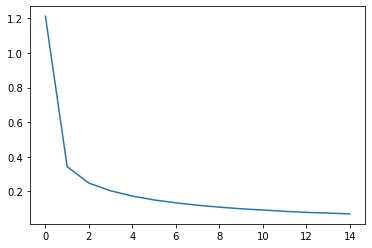

In [14]:
plt.plot(training_loss)

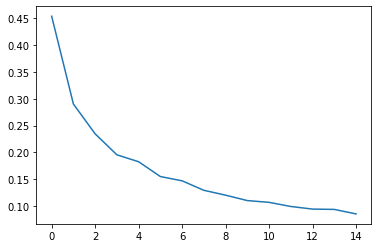

In [15]:
plt.plot(validation_loss)

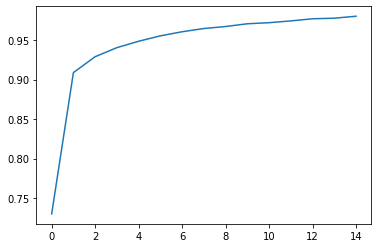

In [16]:
plt.plot(training_accs)

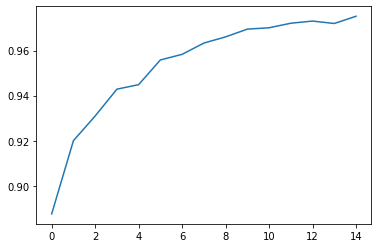

In [17]:
plt.plot(validation_accs)

In [18]:
validation_accs[-1]

0.9752380952380952

In [19]:
torch.save(model.state_dict, "/content/gdrive/MyDrive/Colab Notebooks/digitrecognizermodel_{:.4f}.pth".format(validation_accs[-1]))

# Predictions #

In [20]:
test_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/kaggle-data/kaggle-digitrecognizer/test.csv')
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,20,0,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
X_test = test_df.to_numpy()
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = np.reshape(X_test, (len(X_test), 1, 28, 28))

test_dl = DataLoader(X_test, 1)
test_dl = DeviceDataLoader(test_dl, device)

len(test_dl), X_test.shape

(28000, torch.Size([28000, 1, 28, 28]))

In [28]:
ids = []
preds = []

for i, X_batch in enumerate(test_dl):
  outputs = model(X_batch)
  _, pred = torch.max(outputs, dim=1)
  preds.append(pred.item())
  ids.append(i + 1)

In [29]:
submission_df = pd.DataFrame({
    'ImageId': ids,
    'Label': preds
})

submission_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/submission_{:.4f}.csv".format(validation_accs[-1]), index=False)

In [31]:
len(preds)

28000

In [ ]:
# final kaggle accuracy: 0.97550